# PROJECT 2  -  PART II

Build an RNN LSTM for predicting ETF prices using time-series data and evaluate performance of a trading stategy based on LSTM forecasted price with that of classical MA driven strategy.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


from finta import TA

%matplotlib inline


# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Bad key savefig.frameon in file /Users/adnanquaderi/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/adnanquaderi/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/adnanquaderi/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout

## Set Seed for reproducibility

In [2]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
import tensorflow as tf
import tensorflow.keras.backend as K

K.clear_session()
tf.keras.backend.clear_session()
np.random.seed(2)
tf.random.set_seed(2)


In [3]:
import os
from dotenv import load_dotenv
load_dotenv('penn.env')
import requests
quandl_key = os.getenv("QUANDL_KEY")

In [4]:
# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

Import Classification Libraries

In [5]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [6]:
#Set Processor to Run computations in backend
print(tf.config.list_physical_devices(device_type=None))
tf.config.optimizer.set_jit(True)
gpus = tf.config.list_physical_devices('XLA_CPU') #Our normal laptops have Accelerated Linear Algebra Processor (XLA) activate it through C API
if gpus:
  # Restrict TensorFlow to only use some XLA_CPU
    try:
        tf.config.experimental.set_visible_devices(gpus[:], 'XLA_CPU')
        logical_gpus = tf.config.experimental.list_logical_devices('XLA_CPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
        print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))#@ 
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Instructions

### Initial Setup

To ensure models' reproducibility, set the random seed for `numpy` and `tensorflow` libraries.


### Data Preparation  - API is not used for this portoion of project but is elswhere; code retained for future re-use.  
In this section data will be read in from csv files and converted to panadas dataframe for use. 


##########################################################################################################################################

#### Data Retrieval

In this section, there is placehold code to retrieve Gold historical prices from the London Bullion Market Association using the [Quandl API](https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing).

Import  Quandl API key from an environment variable named `quandl_key`.

In [ ]:
# # Import the API key for QUANDL
# import os
# from pathlib import Path
# from dotenv import load_dotenv
# load_dotenv('penn.env')
# quandl_key = os.getenv("QUANDL_KEY")

In [ ]:
# print(quandl_key)

Open the ["Gold Price: London Fixing" at the Quandl website](https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing), and set the URL to retrieve the historical prices of gold in `json` format.

In [ ]:
# # Set Gold price URL
# request_url = "https://www.quandl.com/api/v3/datasets/LBMA/GOLD.json?api_key="

# gold_prices_url = request_url + quandl_key

Use the `requests` library to retrieve the historical prices of gold in `json` format.

In [ ]:
# # Fetch Gold prices from QUANDL
# import requests
# # 
# # response_data = requests.get(gold_prices_url).json()

Explore the `json` response data and create a Pandas DataFrame containing the historical prices of gold in all the different currencies provided by the API, and set the data as the index of the DataFrame.

DataFrame should look like the following sample:


![Sample gold prices DataFrame](../Images/sample-gold-prices-df.png)

**Note:** While working with time-series data, it's important to transform dates data to `datetime` data type explicitly. R
    Can reveiw [Quandl API documentation for time-series data](https://docs.quandl.com/docs/time-series) if needed.
    
    

In [ ]:
# Explore the `response_data` object

# Fetch the keys of the `response_data` object
# response_data.keys()


In [ ]:
# Explore the contents of the main key
# response_data["dataset"]

In [ ]:
# # Create a DataFrame with Gold prices
# # gold_df = pd.DataFrame(
# #     response_data["dataset"]["data"], 
# #     columns=response_data["dataset"]["column_names"],
# # )

# #Transform the "Date" column to datetime
# gold_df['Date']= pd.to_datetime(gold_df['Date'])

# # Set the "Date" column as the DataFrame Index
# gold_df.set_index("Date", inplace=True)

# # # Show the DataFrame head
# # gold_df.head()

##############################################################################################################

##  Read csv file and convert to dataframe  - Data Processing Starts here

In [7]:
# Import the apple dataset into a Pandas Dataframe
df_read = pd.read_csv(
    Path("aapl.csv"), 
    index_col=0, 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
df = df_read.copy()
df.head()

close    volume    open    high     low
date                                                
2014-09-22  101.06  52421660  101.80  102.14  100.58
2014-09-23  102.64  63255860  100.60  102.94  100.54
2014-09-24  101.75  59974260  102.16  102.85  101.20
2014-09-25   97.87  99689300  100.51  100.71   97.72
2014-09-26  100.75  62276770   98.53  100.75   98.40

In [8]:
df.tail()

close    volume    open    high     low
date                                                
2019-09-13  218.75  39763300  220.00  220.79  217.02
2019-09-16  219.90  21158140  217.73  220.13  217.56
2019-09-17  220.70  18386470  219.96  220.82  219.12
2019-09-18  222.77  25643090  221.06  222.85  219.44
2019-09-19  220.96  22187880  222.01  223.76  220.37

In [9]:
# Import SPY Data
df_spy = pd.read_csv(
    Path("spy1.csv"), 
    index_col=0, 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
df_spy.head(5)

close     volume   open       high    low
date                                                  
2009-01-02  92.960  227638523  90.44  93.440000  89.85
2009-01-05  92.850  240697608  92.63  94.553313  91.89
2009-01-06  93.470  328481747  93.64  94.450000  92.68
2009-01-07  90.670  281047574  92.00  92.260000  90.20
2009-01-08  91.042  263834401  90.16  91.090000  89.67

In [10]:
df_spy.tail(5)

close    volume    open    high     low
date                                                
2021-12-27  477.26  56808619  472.06  477.31  472.01
2021-12-28  476.87  47274585  477.72  478.81  476.06
2021-12-29  477.48  54502964  476.98  478.56  475.92
2021-12-30  476.16  55329041  477.93  479.00  475.67
2021-12-31  474.96  65237431  475.64  476.86  474.67



#### Data Cleaning

Before continue, corroborate if there are any `null` or missing values in the DataFrame, if so, fill the missing values with the previous price in the series.

**Note:** You may want to review the [Working with missing data guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) from the Pandas documentation.

In [11]:
# Looking for missing values
df.isnull().sum().sum()

0

In [12]:
# Filling missing values with the previous ones
df = df.fillna(method ='pad')

_______________

### Code for Multi-feature (FYI - this was not used to fit the model)

In [ ]:
multi_df = df[["close","volume"]].copy()


In [ ]:
multi_df['VWAP'] = (multi_df.volume*(multi_df.close)).cumsum() / multi_df.volume.cumsum()


In [ ]:
multi_df.head()

In [ ]:




multi_df.shape

In [ ]:
model_data = multi_df[["close","VWAP"]]
model_data.shape

In [ ]:

# model_data.values.reshape(-1, 1, 2).shape

In [ ]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:, 0] # 0 is basically telling us that column 0 is the target
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [ ]:
X, y = create_multivariate_rnn_data(model_data.values, window_size=50)

In [ ]:

X.shape, y.shape



______

## LSTM Model to Forecast Prices starts here

### Create the Features `X` and Target `y` Data

In [13]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [14]:
# Define the window size
window_size = 50

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[101.06  102.64  101.75   97.87  100.75  100.11  100.75   99.18   99.9
   99.62   99.62   98.75  100.8   101.02  100.73   99.81   98.75   97.54
   96.26   97.67   99.76  102.47  102.99  104.83  105.22  105.11  106.74
  107.34  106.98  108.    109.4   108.6   108.86  108.7   109.01  108.83
  109.7   111.25  112.82  114.18  113.99  115.47  114.67  116.31  116.47
  118.625 117.6   119.    118.93  115.07 ]
 [102.64  101.75   97.87  100.75  100.11  100.75   99.18   99.9    99.62
   99.62   98.75  100.8   101.02  100.73   99.81   98.75   97.54   96.26
   97.67   99.76  102.47  102.99  104.83  105.22  105.11  106.74  107.34
  106.98  108.    109.4   108.6   108.86  108.7   109.01  108.83  109.7
  111.25  112.82  114.18  113.99  115.47  114.67  116.31  116.47  118.625
  117.6   119.    118.93  115.07  114.63 ]
 [101.75   97.87  100.75  100.11  100.75   99.18   99.9    99.62   99.62
   98.75  100.8   101.02  100.73   99.81   98.75   97.54   96.26   97.67
   99.76  102.47  102.

In [15]:
X.shape, y.shape

((1208, 50), (1208, 1))

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [16]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [17]:

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((845, 50), (845, 1), (363, 50), (363, 1))

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [18]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [19]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.1205578 ]
  [0.13832659]
  [0.12831759]
  [0.08468286]
  [0.11707152]
  [0.10987404]
  [0.11707152]
  [0.0994152 ]
  [0.10751237]
  [0.10436347]
  [0.10436347]
  [0.0945794 ]
  [0.11763383]
  [0.12010796]
  [0.1168466 ]
  [0.10650022]
  [0.0945794 ]
  [0.08097166]
  [0.0665767 ]
  [0.08243365]
  [0.10593792]
  [0.13641475]
  [0.14226271]
  [0.16295547]
  [0.16734143]
  [0.16610436]
  [0.18443545]
  [0.19118309]
  [0.18563141]
  [0.19325892]
  [0.20857956]
  [0.19982491]
  [0.20267017]
  [0.20091924]
  [0.20431167]
  [0.20234187]
  [0.21186255]
  [0.22882469]
  [0.24600569]
  [0.2608886 ]
  [0.25880937]
  [0.27500547]
  [0.26625082]
  [0.28419786]
  [0.28594879]
  [0.30953163]
  [0.29831473]
  [0.31363537]
  [0.31286934]
  [0.27062815]]

 [[0.13832659]
  [0.12831759]
  [0.08468286]
  [0.11707152]
  [0.10987404]
  [0.11707152]
  [0.0994152 ]
  [0.10751237]
  [0.10436347]
  [0.10436347]
  [0.0945794 ]
  [0.11763383]
  [0.12010796]
  [0.1168466 ]
  [0.10650022]


---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

### Create the LSTM RNN Model Structure

Design the structure of your RNN LSTM as follows:

* Number of units per layer: same as the window size

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to the model, and add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [20]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = (4 * window_size + 1)
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units= number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))


#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [21]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [22]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 201)           163212    
                                                                 
 dropout (Dropout)           (None, 50, 201)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 201)           324012    
                                                                 
 dropout_1 (Dropout)         (None, 50, 201)           0         
                                                                 
 lstm_2 (LSTM)               (None, 201)               324012    
                                                                 
 dropout_2 (Dropout)         (None, 201)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((845, 50, 1), (845, 1), (363, 50, 1), (363, 1))

### Add Early Stopping Feature and Train the model

New library to meet technical requirement

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss',
                               patience = 5,
                               mode='min',
                               restore_best_weights=True)


In [25]:
# Train the model

model.fit(X_train, y_train, epochs=100, shuffle=False, 
          batch_size=64, verbose=1, validation_data=(X_test, y_test), 
          callbacks=[early_stopping])


Epoch 1/100
14/14 [==============================] - 6s 252ms/step - loss: 0.0581 - val_loss: 0.0737
Epoch 2/100
14/14 [==============================] - 3s 215ms/step - loss: 0.0558 - val_loss: 0.0320
Epoch 3/100
14/14 [==============================] - 3s 199ms/step - loss: 0.1061 - val_loss: 0.1628
Epoch 4/100
14/14 [==============================] - 3s 195ms/step - loss: 0.0246 - val_loss: 0.0089
Epoch 5/100
14/14 [==============================] - 3s 198ms/step - loss: 0.0073 - val_loss: 0.0374
Epoch 6/100
14/14 [==============================] - 3s 200ms/step - loss: 0.0063 - val_loss: 0.0081
Epoch 7/100
14/14 [==============================] - 3s 200ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 8/100
14/14 [==============================] - 3s 201ms/step - loss: 0.0071 - val_loss: 0.0192
Epoch 9/100
14/14 [==============================] - 3s 204ms/step - loss: 0.0055 - val_loss: 0.0073
Epoch 10/100
14/14 [==============================] - 3s 205ms/step - loss: 0.0047 - val_lo

In [26]:
# Checkpoint code placeholder for future use

#model.compile()
# lstm_path = (results_path / 'lstm.h5').as_posix()

# checkpointer = ModelCheckpoint(filepath=lstm_path,
#                                verbose=1,
#                                monitor='val_loss',
#                                mode='min',
#                                save_best_only=True)
# pd.DataFrame(model.history).plot();

---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [32]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.007933484390377998

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [33]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)


In [34]:
from tensorflow.keras.losses import MeanSquaredError

mse = MeanSquaredError()
mse(y_test, predicted).numpy()


0.007933486

Since you scaled the original values using the `MinMaxScaler`, you need to recover the original gold prices to better understand of the predictions. Use the `inverse_transform()` method of the scaler to decode the scaled testing and predicted values to their original scale.

In [35]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))



In [36]:
#Estimate amount you expect Forecasted price to be OFF by most of the time

mse = MeanSquaredError()
np.sqrt(mse(real_prices, predicted_prices).numpy()) #you expect to be OFF by this much most of the time


8.139231



#### Plotting Predicted Vs. Real Prices

Create a Pandas DataFrame with an index and two columns as follows to plot the predicted vs. the actual gold prices.

* Index: The datetime index from the DataFrame created previously. 

* Column 1: Actual prices (testing data)

* Column 2: Predicted prices

Your DataFrame should look like the sample below:

![Sample actual vs. predicted gold prices](../Images/sample-gold-prices-predictions-df.png)

In [37]:
# Create a DataFrame of Real and Predicted value
Predicted_LSTM = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
Predicted_LSTM.head()


Actual   Predicted
date                          
2018-04-12  174.14  169.206833
2018-04-13  174.73  169.629700
2018-04-16  175.82  170.156403
2018-04-17  178.24  170.774429
2018-04-18  177.84  171.513306

Use the `plot()` method from the DataFrame to create a line chart to contrast the actual vs. the predicted gold prices.

In [38]:
# Plot the real vs predicted prices on test data as a line chart
Predicted_LSTM.hvplot(title="Apple :  Actual Vs. LSTM Forecasted Prices on Test data")

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [39]:
Predicted_LSTM["Signal"] = 0
Predicted_LSTM.head()

Actual   Predicted  Signal
date                                  
2018-04-12  174.14  169.206833       0
2018-04-13  174.73  169.629700       0
2018-04-16  175.82  170.156403       0
2018-04-17  178.24  170.774429       0
2018-04-18  177.84  171.513306       0

In [40]:
Predicted_LSTM["predicted_returns"] = Predicted_LSTM["Predicted"].pct_change()
Predicted_LSTM["actual_returns"] = Predicted_LSTM["Actual"].pct_change()
Predicted_LSTM.head(10)

Actual   Predicted  Signal  predicted_returns  actual_returns
date                                                                     
2018-04-12  174.14  169.206833       0                NaN             NaN
2018-04-13  174.73  169.629700       0           0.002499        0.003388
2018-04-16  175.82  170.156403       0           0.003105        0.006238
2018-04-17  178.24  170.774429       0           0.003632        0.013764
2018-04-18  177.84  171.513306       0           0.004327       -0.002244
2018-04-19  172.80  172.323059       0           0.004721       -0.028340
2018-04-20  165.72  172.994385       0           0.003896       -0.040972
2018-04-23  165.24  173.246201       0           0.001456       -0.002896
2018-04-24  162.94  173.036682       0          -0.001209       -0.013919
2018-04-25  163.65  172.376556       0          -0.003815        0.004357

Create Trading Signal based on LSTM Predicted close prices, shift predicted_returns up one (T+1 Forecast drives trade on T)

In [41]:
Predicted_LSTM["lstm_forecasted_returns"] = Predicted_LSTM["Predicted"].pct_change().shift(-1)
Predicted_LSTM.head()

Actual   Predicted  Signal  predicted_returns  actual_returns  lstm_forecasted_returns
date                                                                                              
2018-04-12  174.14  169.206833       0                NaN             NaN                 0.002499
2018-04-13  174.73  169.629700       0           0.002499        0.003388                 0.003105
2018-04-16  175.82  170.156403       0           0.003105        0.006238                 0.003632
2018-04-17  178.24  170.774429       0           0.003632        0.013764                 0.004327
2018-04-18  177.84  171.513306       0           0.004327       -0.002244                 0.004721

In [42]:
Predicted_LSTM = Predicted_LSTM.dropna().copy()

# Create the signal to buy 
Predicted_LSTM.loc[(Predicted_LSTM["lstm_forecasted_returns"] >= 0), "Signal"] = 1  # predicted returns shifted -1

# Create the signal to sell
Predicted_LSTM.loc[(Predicted_LSTM["lstm_forecasted_returns"] < 0), "Signal"] = -1

Predicted_LSTM['Entry/Exit'] = Predicted_LSTM['Signal'].diff()

In [43]:
Predicted_LSTM.head(5)

Actual   Predicted  Signal  predicted_returns  actual_returns  lstm_forecasted_returns  Entry/Exit
date                                                                                                          
2018-04-13  174.73  169.629700       1           0.002499        0.003388                 0.003105         NaN
2018-04-16  175.82  170.156403       1           0.003105        0.006238                 0.003632         0.0
2018-04-17  178.24  170.774429       1           0.003632        0.013764                 0.004327         0.0
2018-04-18  177.84  171.513306       1           0.004327       -0.002244                 0.004721         0.0
2018-04-19  172.80  172.323059       1           0.004721       -0.028340                 0.003896         0.0

In [44]:
Predicted_LSTM['lstm_return']=Predicted_LSTM['Signal']*Predicted_LSTM['actual_returns']
Predicted_LSTM['cum_lstm_return'] = 100*((1 + Predicted_LSTM.lstm_return).cumprod()-1)
Predicted_LSTM['cum_lstm_return'].hvplot(title="Cumulative Return on strategy based on LSTM Forecast on test data")

                                                

:Curve   [date]   (cum_lstm_return)

In [45]:
Predicted_LSTM.loc['2021-02-01':'2021-04-01']

Empty DataFrame
Columns: [Actual, Predicted, Signal, predicted_returns, actual_returns, lstm_forecasted_returns, Entry/Exit, lstm_return, cum_lstm_return]
Index: []

### Visualize Entry / Exit on Price and Cumulative Return Charts

In [46]:
# Visualize exit position relative to LSTM Predicted Price
exit_predicted = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['Actual'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Security Price',
    width=1000,
    height=400
)

# # Visualize exit position relative to Actual Price
# exit_actual = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['Actual'].hvplot.scatter(
#     color='red',
#     marker='v',
#     legend=False,
#     ylabel='Security Price',
#     width=1000,
#     height=400
# )


# Visualize entry position relative to LSTM Predicted Price
entry_predicted = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['Actual'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Security Price',
    width=1000,
    height=400
)

# # Visualize entry position relative to Actual Price
# entry_actual = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['Actual'].hvplot.scatter(
#     color='green',
#     marker='^',
#     ylabel='Security Price',
#     width=1000,
#     height=400
# )

# Visualize the LSTM Predicted time series of the security
predicted_price = Predicted_LSTM[['Predicted']].hvplot(
    line_color='lightblue',
    ylabel='Security Price',
    xlabel='Date',
    width=1000,
    height=400
)

# Visualize the Actual Price time series of the security
actual_price = Predicted_LSTM[['Actual']].hvplot(
    line_color='lightgray',
    ylabel='Predicted',
    xlabel='Date',
    width=1000,
    height=400
)


# Overlay the plots
#portfolio_entry_exit_plot = total_portfolio_value * entry_predicted * exit_predicted * entry_actual * exit_actual * Actual_price

lstm_entry_exit_plot = predicted_price * entry_predicted * exit_predicted * actual_price

lstm_entry_exit_plot.opts(
    title="Apple: LSTM Forcasted Prices with Entry / Exit Markers vs Actual Price Historry - Test Series",
    yformatter='%.0f', legend_position='top_left' 
)


:Overlay
   .Curve.I           :Curve   [date]   (Predicted)
   .Scatter.Actual.I  :Scatter   [date]   (Actual)
   .Scatter.Actual.II :Scatter   [date]   (Actual)
   .Curve.II          :Curve   [date]   (Actual)

In [47]:
# Visualize exit position relative to total portfolio return
# LSTM_exit = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['Portfolio Total'].hvplot.scatter(
#     color='red',
#     marker='v',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to total portfolio value
# LSTM_entry = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['Portfolio Total'].hvplot.scatter(
#     color='green',
#     marker='^',
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# Visualize exit position relative to total portfolio value
lstm_exit = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['cum_lstm_return'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='LSTM - Cumulative Portfolio Return',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
lstm_entry = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['cum_lstm_return'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='LSTM - Cumulative Portfolio Return',
    width=1000,
    height=400
)

# # Visualize the value of the total portfolio
# LSTM_total_portfolio_value = Predicted_LSTM[['Portfolio Total']].hvplot(
#     line_color='lightgray',
#     ylabel='Total Portfolio Value',
#     xlabel='Date',
#     width=1000,
#     height=400
# )

# Visualize the value of the total portfolio
lstm_portfolio_cum_return = Predicted_LSTM[['cum_lstm_return']].hvplot(
    line_color='lightgray',
    ylabel='LSTM - Cumulative Portfolio Return',
    xlabel='Date',
    width=1000,
    height=400
)

# # Visualize LSTM Predicted security Timeseries / Price
# Predicted_Stock_Price = Predicted_LSTM[['Predicted']].hvplot(
#     line_color='blue',
#     ylabel='Predicted',
#     xlabel='Date',
#     width=1000,
#     height=400
# )

# # Visualize Actual security Timeseries / Price
# Actual_Stock_Price = Predicted_LSTM[['Actual']].hvplot(
#     line_color='blue',
#     ylabel='Predicted',
#     xlabel='Date',
#     width=1000,
#     height=400
# )


# Overlay the plots  [Prices shown on plot above to preserve chart scaling]
lstm_cum_return_entry_exit_plot = lstm_portfolio_cum_return * lstm_entry * lstm_exit
lstm_cum_return_entry_exit_plot.opts(
    title="Apple - LSTM Forecast Driven Trading Signal & Cumulative Return o",
    yformatter='%.0f', legend_position='top_left' 
)


:Overlay
   .Curve.I                    :Curve   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.I  :Scatter   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.II :Scatter   [date]   (cum_lstm_return)

In [48]:
#Predicted_LSTM['cum_lstm_return'].hvplot(title="Apple - LSTM Forecast Driven Trading Signal & Cumulative Return over Test Period")


# Technical Analysis using FINTA 

Import Data again (Actual Prices)

In [49]:
# Read the stock file to a dataframe
# Set the date column as the DataTimeIndex
df_ta = pd.read_csv(
    Path("aapl.csv"),
    index_col="date",
    parse_dates=True,
    infer_datetime_format=True)

from finta import TA

# Review the DataFrame
df_ta.head()


close    volume    open    high     low
date                                                
2014-09-22  101.06  52421660  101.80  102.14  100.58
2014-09-23  102.64  63255860  100.60  102.94  100.54
2014-09-24  101.75  59974260  102.16  102.85  101.20
2014-09-25   97.87  99689300  100.51  100.71   97.72
2014-09-26  100.75  62276770   98.53  100.75   98.40

In [50]:
# Slice to just the `close` column
#signals_df = aapl_df.loc[:,["close"]]
signals_df = df_ta.loc['2018-04-02':].copy()
signals_df.head(5)


close    volume    open      high     low
date                                                  
2018-04-02  166.68  37425640  167.88  168.9400  164.47
2018-04-03  168.39  30237640  167.64  168.7455  164.88
2018-04-04  171.61  34581850  164.88  172.0100  164.77
2018-04-05  172.80  26750260  172.58  174.2304  172.08
2018-04-06  168.38  34949690  170.97  172.4800  168.20

In [51]:
signals_df.tail(5)

close    volume    open    high     low
date                                                
2019-09-13  218.75  39763300  220.00  220.79  217.02
2019-09-16  219.90  21158140  217.73  220.13  217.56
2019-09-17  220.70  18386470  219.96  220.82  219.12
2019-09-18  222.77  25643090  221.06  222.85  219.44
2019-09-19  220.96  22187880  222.01  223.76  220.37

Optional Calcualtion of Moving Average via normal code; not used for this project but retained for future use if finta unavailable

In [52]:
# # Set the short window and long windows
# short_window = 50
# long_window = 100


In [53]:
# # Generate the short and long moving averages (50 and 100 days, respectively)
# signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
# signals_df['SMA100'] = signals_df['close'].rolling(window=long_window).mean()

# # Prepopulate the `Signal` for trading
# signals_df['Signal'] = 0.0

## Calculation of Tecnhinal Indicators via FINTA

In [54]:
# Create a signals_df DataFrame 


# Set the short window and long windows
short_window = 10
long_window = 30

# Add the SMA technical indicators for the short and long windows
signals_df["Short_MA"] = TA.SMA(signals_df, short_window)
signals_df["Long_MA"] = TA.SMA(signals_df, long_window)

# # Replace the SMA moving average calculations with an alternative moving average 
# # calculation from the finta library
#signals_df["Short_DEMA"] = TA.DEMA(signals_df, short_window)
#signals_df["Long_DEMA"] = TA.DEMA(signals_df, long_window)

# Review the DataFrame
signals_df.iloc[95:105, :]


close    volume    open      high      low  Short_MA     Long_MA
date                                                                         
2018-08-15  210.24  28595230  209.22  210.7400  208.330   208.408  197.034000
2018-08-16  213.32  27595310  211.75  213.8121  211.470   209.001  197.964667
2018-08-17  217.58  35034410  213.44  217.9500  213.160   209.960  198.951667
2018-08-20  215.46  30149410  218.10  219.1800  215.110   210.599  199.781000
2018-08-21  215.04  25682700  216.80  217.1900  214.025   211.392  200.604000
2018-08-22  215.05  18965930  214.10  216.3600  213.840   212.172  201.509667
2018-08-23  215.49  18505780  214.65  217.0500  214.600   212.833  202.325000
2018-08-24  216.16  18457720  216.60  216.9000  215.110   213.696  203.152667
2018-08-27  217.94  20400770  217.15  218.7400  216.330   214.603  204.053667
2018-08-28  219.70  22751390  219.01  220.5400  218.920   215.598  204.995333

In [55]:
signals_df.tail()

close    volume    open    high     low  Short_MA     Long_MA
date                                                                      
2019-09-13  218.75  39763300  220.00  220.79  217.02  214.6465  207.945500
2019-09-16  219.90  21158140  217.73  220.13  217.56  215.7625  208.474833
2019-09-17  220.70  18386470  219.96  220.82  219.12  217.2625  209.386833
2019-09-18  222.77  25643090  221.06  222.85  219.44  218.6205  210.245833
2019-09-19  220.96  22187880  222.01  223.76  220.37  219.3885  210.976500

In [56]:
# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than or equal to the long (SMA 100)
# and 1 otherwise
# In this TA strategy just as with lstm, trader is always in the market either long or short based on the indicative forecast

signals_df["Signal"] = 0
signals_df['Signal'][short_window:] = np.where(
    signals_df['Short_MA'][short_window:] >= signals_df['Long_MA'][short_window:], 1.0, -1.0
)
signals_df.iloc[50:75, :]


close    volume     open      high       low  Short_MA     Long_MA  Signal
date                                                                                   
2018-06-12  192.28  16859020  191.385  192.6110  191.1500   191.240  187.328000     1.0
2018-06-13  190.70  21480120  192.420  192.8800  190.4400   191.560  188.048000     1.0
2018-06-14  190.80  21584720  191.550  191.5700  190.2200   191.953  188.522333     1.0
2018-06-15  188.84  61438290  190.030  190.1600  188.2600   191.813  188.920667     1.0
2018-06-18  188.74  18458410  187.880  189.2200  187.2000   191.504  189.084333     1.0
2018-06-19  185.69  33538550  185.140  186.3300  183.4500   190.742  189.102000     1.0
2018-06-20  186.50  20490090  186.350  187.2000  185.7300   189.994  189.117000     1.0
2018-06-21  185.46  25649240  187.250  188.3500  184.9400   189.194  189.053667     1.0
2018-06-22  184.92  27185130  186.120  186.1500  184.7000   188.516  188.883000    -1.0
2018-06-25  182.17  31632320  183.400  184.9200  180.7300   187.610  188.669000    -1.0
2018-06-26  184.43  24378480  182.990  186.5300  182.5400   186.825  188.545000    -1.0
2018-06-27  184.16  24987260  185.228  187.2800  184.0300   186.171  188.469000    -1.0
2018-06-28  185.50  17352380  184.100  186.2100  183.8000   185.641  188.379667    -1.0
2018-06-29  185.11  22551660  186.290  187.1900  182.9100   185.268  188.317000    -1.0
2018-07-02  187.18  17675210  183.820  187.3000  183.4200   185.112  188.346000    -1.0
2018-07-03  183.92  13954810  187.790  187.9500  183.5400   184.935  188.222333    -1.0
2018-07-05  185.40  16543880  185.260  186.4100  184.2800   184.825  188.163667    -1.0
2018-07-06  187.97  17426160  185.420  188.4340  185.2000   185.076  188.150667    -1.0
2018-07-09  190.58  19636390  189.500  190.6800  189.3000   185.642  188.231667    -1.0
2018-07-10  190.35  15801370  190.710  191.2800  190.1801   186.460  188.290667    -1.0
2018-07-11  187.88  18776390  188.500  189.7799  187.6100   186.805  188.290000    -1.0
2018-07-12  191.03  18000180  189.530  191.4100  189.3100   187.492  188.407667    -1.0
2018-07-13  191.33  12506830  191.080  191.8400  190.9000   188.075  188.556333    -1.0
2018-07-16  190.91  15009800  191.520  192.6500  190.4150   188.655  188.578667     1.0
2018-07-17  191.45  15515000  189.750  191.8700  189.2000   189.082  188.566000     1.0

In [57]:

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
signals_df.iloc[0:20, :]


close    volume      open      high       low  Short_MA  Long_MA  Signal  Entry/Exit
date                                                                                             
2018-04-02  166.68  37425640  167.8800  168.9400  164.4700       NaN      NaN     0.0         NaN
2018-04-03  168.39  30237640  167.6400  168.7455  164.8800       NaN      NaN     0.0         0.0
2018-04-04  171.61  34581850  164.8800  172.0100  164.7700       NaN      NaN     0.0         0.0
2018-04-05  172.80  26750260  172.5800  174.2304  172.0800       NaN      NaN     0.0         0.0
2018-04-06  168.38  34949690  170.9700  172.4800  168.2000       NaN      NaN     0.0         0.0
2018-04-09  170.05  28976200  169.8800  173.0900  169.8450       NaN      NaN     0.0         0.0
2018-04-10  173.25  28567110  173.0000  174.0000  171.5300       NaN      NaN     0.0         0.0
2018-04-11  172.44  22401040  172.2300  173.9232  171.7000       NaN      NaN     0.0         0.0
2018-04-12  174.14  22858840  173.4100  175.0000  173.0400       NaN      NaN     0.0         0.0
2018-04-13  174.73  25100510  174.7800  175.8400  173.8500   171.247      NaN     0.0         0.0
2018-04-16  175.82  21561320  175.0301  176.1900  174.8301   172.161      NaN    -1.0        -1.0
2018-04-17  178.24  26575010  176.4900  178.9365  176.4100   173.146      NaN    -1.0         0.0
2018-04-18  177.84  20544600  177.8100  178.8200  176.8800   173.769      NaN    -1.0         0.0
2018-04-19  172.80  34693280  174.9500  175.3900  172.6600   173.769      NaN    -1.0         0.0
2018-04-20  165.72  65270950  170.5950  171.2184  165.4300   173.503      NaN    -1.0         0.0
2018-04-23  165.24  36396590  166.8350  166.9200  164.0900   173.022      NaN    -1.0         0.0
2018-04-24  162.94  33674960  165.6700  166.3300  161.2201   171.991      NaN    -1.0         0.0
2018-04-25  163.65  28331540  162.6200  165.4200  162.4100   171.112      NaN    -1.0         0.0
2018-04-26  164.22  27850370  164.1200  165.7300  163.3700   170.120      NaN    -1.0         0.0
2018-04-27  162.32  35617230  164.0000  164.3300  160.6300   168.879      NaN    -1.0         0.0

In [58]:
signals_df["actual_returns"] = signals_df["close"].pct_change()
signals_df["actual_returns_shifted"] = Predicted_LSTM["actual_returns"].shift(-1)
signals_df.iloc[210:230, :]

close    volume    open      high       low  Short_MA     Long_MA  Signal  Entry/Exit  actual_returns  actual_returns_shifted
date                                                                                                                                      
2019-01-31  166.44  40613260  166.11  169.0000  164.5600   157.303  154.871000     1.0         0.0        0.007201                0.000481
2019-02-01  166.52  32644590  166.96  168.9800  165.9300   158.369  154.886000     1.0         0.0        0.000481                0.028405
2019-02-04  171.25  31384720  167.41  171.6550  167.2800   159.812  155.231333     1.0         0.0        0.028405                0.017109
2019-02-05  174.18  36054570  172.86  175.0800  172.3501   161.900  155.809667     1.0         0.0        0.017109                0.000344
2019-02-06  174.24  28204640  174.65  175.5700  172.8531   163.932  156.593333     1.0         0.0        0.000344               -0.018939
2019-02-07  170.94  31644240  172.40  173.9400  170.3400   165.756  157.397000     1.0         0.0       -0.018939               -0.003101
2019-02-08  170.41  23793830  168.99  170.6600  168.4200   167.021  157.838333     1.0         0.0       -0.003101               -0.005751
2019-02-11  169.43  20940020  171.05  171.2100  169.2500   168.334  158.281000     1.0         0.0       -0.005751                0.008617
2019-02-12  170.89  22224400  170.10  171.0000  169.7000   169.955  158.769667     1.0         0.0        0.008617               -0.004155
2019-02-13  170.18  22389660  171.39  172.4800  169.9200   170.448  159.184333     1.0         0.0       -0.004155                0.003643
2019-02-14  170.80  21785180  169.71  171.2615  169.3800   170.884  159.613667     1.0         0.0        0.003643               -0.002225
2019-02-15  170.42  24603320  171.25  171.7000  169.7500   171.274  160.554667     1.0         0.0       -0.002225                0.002993
2019-02-19  170.93  18958570  169.71  171.4400  169.4900   171.242  161.310333     1.0         0.0        0.002993                0.006435
2019-02-20  172.03  25323890  171.19  173.3200  170.9900   171.027  162.113667     1.0         0.0        0.006435               -0.005639
2019-02-21  171.06  17154540  171.80  172.3700  170.3000   170.709  162.790667     1.0         0.0       -0.005639                0.011166
2019-02-22  172.97  18890250  171.58  173.0000  171.3800   170.912  163.446000     1.0         0.0        0.011166                0.007285
2019-02-25  174.23  21846400  174.16  175.8700  173.9500   171.294  164.127000     1.0         0.0        0.007285                0.000574
2019-02-26  174.33  16991610  173.71  175.3000  173.1732   171.784  164.861667     1.0         0.0        0.000574                0.003098
2019-02-27  174.87  27817640  173.21  175.0000  172.7300   172.182  165.690667     1.0         0.0        0.003098               -0.009836
2019-02-28  173.15  27953810  174.32  174.9100  172.9200   172.479  166.360000     1.0         0.0       -0.009836                0.010511

In [59]:
signals_df.tail()

close    volume    open    high     low  Short_MA     Long_MA  Signal  Entry/Exit  actual_returns  actual_returns_shifted
date                                                                                                                                  
2019-09-13  218.75  39763300  220.00  220.79  217.02  214.6465  207.945500     1.0         0.0       -0.019432                0.005257
2019-09-16  219.90  21158140  217.73  220.13  217.56  215.7625  208.474833     1.0         0.0        0.005257                0.003638
2019-09-17  220.70  18386470  219.96  220.82  219.12  217.2625  209.386833     1.0         0.0        0.003638                0.009379
2019-09-18  222.77  25643090  221.06  222.85  219.44  218.6205  210.245833     1.0         0.0        0.009379                     NaN
2019-09-19  220.96  22187880  222.01  223.76  220.37  219.3885  210.976500     1.0         0.0       -0.008125                     NaN

In [60]:
# Plot Cumulative Return of TA Forecast based trading strategy

signals_df['ta_return']=signals_df['Signal']*signals_df['actual_returns_shifted']
signals_df['cum_ta_return'] = (100*((1 + signals_df.ta_return).cumprod()-1))
signals_df['cum_ta_return'].hvplot(title="Cumulative Return Technical Anlaysis Strategy - Moving Average Crossover")


:Curve   [date]   (cum_ta_return)

In [61]:
# Visualize exit position relative to actual close price
exit = signals_df[signals_df['Entry/Exit'] == -2.0]['close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to acutal close price
entry = signals_df[signals_df['Entry/Exit'] == 2.0]['close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['Short_MA','Long_MA']].hvplot(
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
price_entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
price_entry_exit_plot.opts(
    title="Apple:  Technical Anlaysis Strategy - Moving Average Crossover Trades & Prices", legend_position='top_left' 
)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [62]:
from matplotlib.ticker import FormatStrFormatter

# Visualize exit position relative to total portfolio value
# TA_exit = signals_df[signals_df['Entry/Exit'] == -2.0]['Portfolio Total'].hvplot.scatter(
#     color='red',
#     marker='v',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to total portfolio value
# TA_entry = signals_df[signals_df['Entry/Exit'] == 2.0]['Portfolio Total'].hvplot.scatter(
#     color='green',
#     marker='^',
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
#)

# Visualize exit position relative to total portfolio value
ta_exit = signals_df[signals_df['Entry/Exit'] == -2.0]['cum_ta_return'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
ta_entry = signals_df[signals_df['Entry/Exit'] == 2.0]['cum_ta_return'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
# TA_total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
#     line_color='purple',
#     ylabel='Total Portfolio Value',
#     xlabel='Date',
#     width=1000,
#     height=400,
#)

# Visualize the value of the total portfolio
ta_cum_return= signals_df[['cum_ta_return']].hvplot(
    line_color='purple',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400,
)

# Overlay the plots
ta_cum_return_entry_exit_plot = ta_cum_return * ta_entry * ta_exit
ta_cum_return_entry_exit_plot.opts(
    title="Apple Algorithm - Total Portfolio Value based on Traditional Technical Analysis",
    yformatter='%.1f%%', legend_position='top_left' 
)

#TA_portfolio_entry_exit_plot.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


:Overlay
   .Curve.I                  :Curve   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.I  :Scatter   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.II :Scatter   [date]   (cum_ta_return)

In [63]:
# Compare LSTM and TA returns
comparison_entry_exit_plot = ta_cum_return_entry_exit_plot * lstm_cum_return_entry_exit_plot
comparison_entry_exit_plot.opts(
    title="Apple: Cum Return Comparison of 2 Approaches - LSTM Forecast based trading strategy vs MA Crossover trading strategy",
    yformatter='%.1f%%', legend_position='top_left' 
)


:Overlay
   .Curve.I                    :Curve   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.I    :Scatter   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.II   :Scatter   [date]   (cum_ta_return)
   .Curve.II                   :Curve   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.I  :Scatter   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.II :Scatter   [date]   (cum_lstm_return)

In [64]:
time_trading = display(len(signals_df))

371

In [65]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()



print(f"LSTM Stdev: {Predicted_LSTM['lstm_return'].std()}")
print(f"TA Stdev: {signals_df['ta_return'].std()}")

LSTM Stdev: 0.018119582663714013
TA Stdev: 0.01839883322471666


<AxesSubplot:title={'center':'Apple: LSTM vs TA Daily Return Box Plot'}>

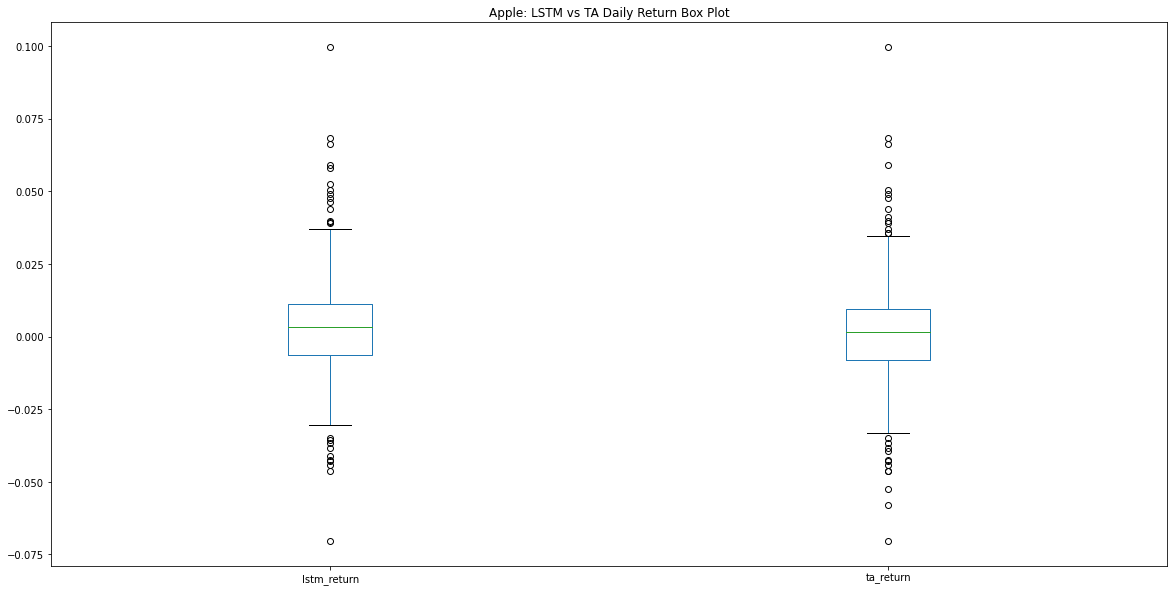

In [66]:
temp_df = pd.concat([lstm_col, signals_col], axis=1)
temp_df.plot.box(figsize=(20, 10), title="Apple: LSTM vs TA Daily Return Box Plot") 

In [67]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()



print(f"LSTM Stdev: {Predicted_LSTM['lstm_return'].std()}")
print(f"TA Stdev: {signals_df['ta_return'].std()}")

LSTM Stdev: 0.018119582663714013
TA Stdev: 0.01839883322471666


In [68]:
lstm_stdev = (np.sqrt(252)*Predicted_LSTM['lstm_return']).rolling(window=63).std()
lstm_stdev = lstm_stdev.dropna()


In [69]:
ta_stdev = (np.sqrt(252)*signals_df['ta_return']).rolling(window=63).std()
ta_stdev =ta_stdev.dropna()

<AxesSubplot:title={'center':'SPY 3m Rolling Volatility'}, xlabel='date'>

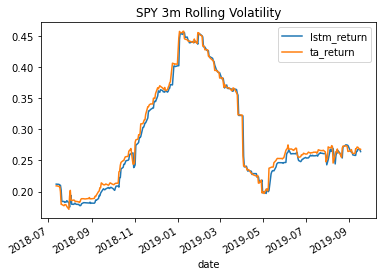

In [70]:
plot_df = pd.concat([lstm_stdev, ta_stdev], axis=1).dropna()
plot_df.plot(title= 'SPY 3m Rolling Volatility')

In [71]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()

<AxesSubplot:title={'center':'SPY Returns'}, xlabel='date'>

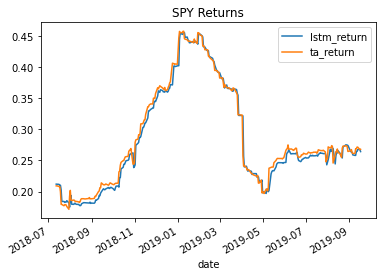

In [72]:
plot_df.plot(title= 'SPY Returns')

In [73]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()

In [74]:
concats = pd.concat([lstm_col, signals_col], axis = 1) # axis = 0 if error
concats.to_csv("PREDICTIONS.csv")

## Use pyfolio to compare LSTM and TA results


In [75]:
# remove your installed pyfolio library
#!pip uninstall pyfolio

# Install it again from its github repo
#!pip install git+https://github.com/quantopian/pyfolio

#!pip install pyfolio==0.9.2

#pip install empyrical==0.3.4


In [76]:
import pyfolio as pf

### LSTM Return Result

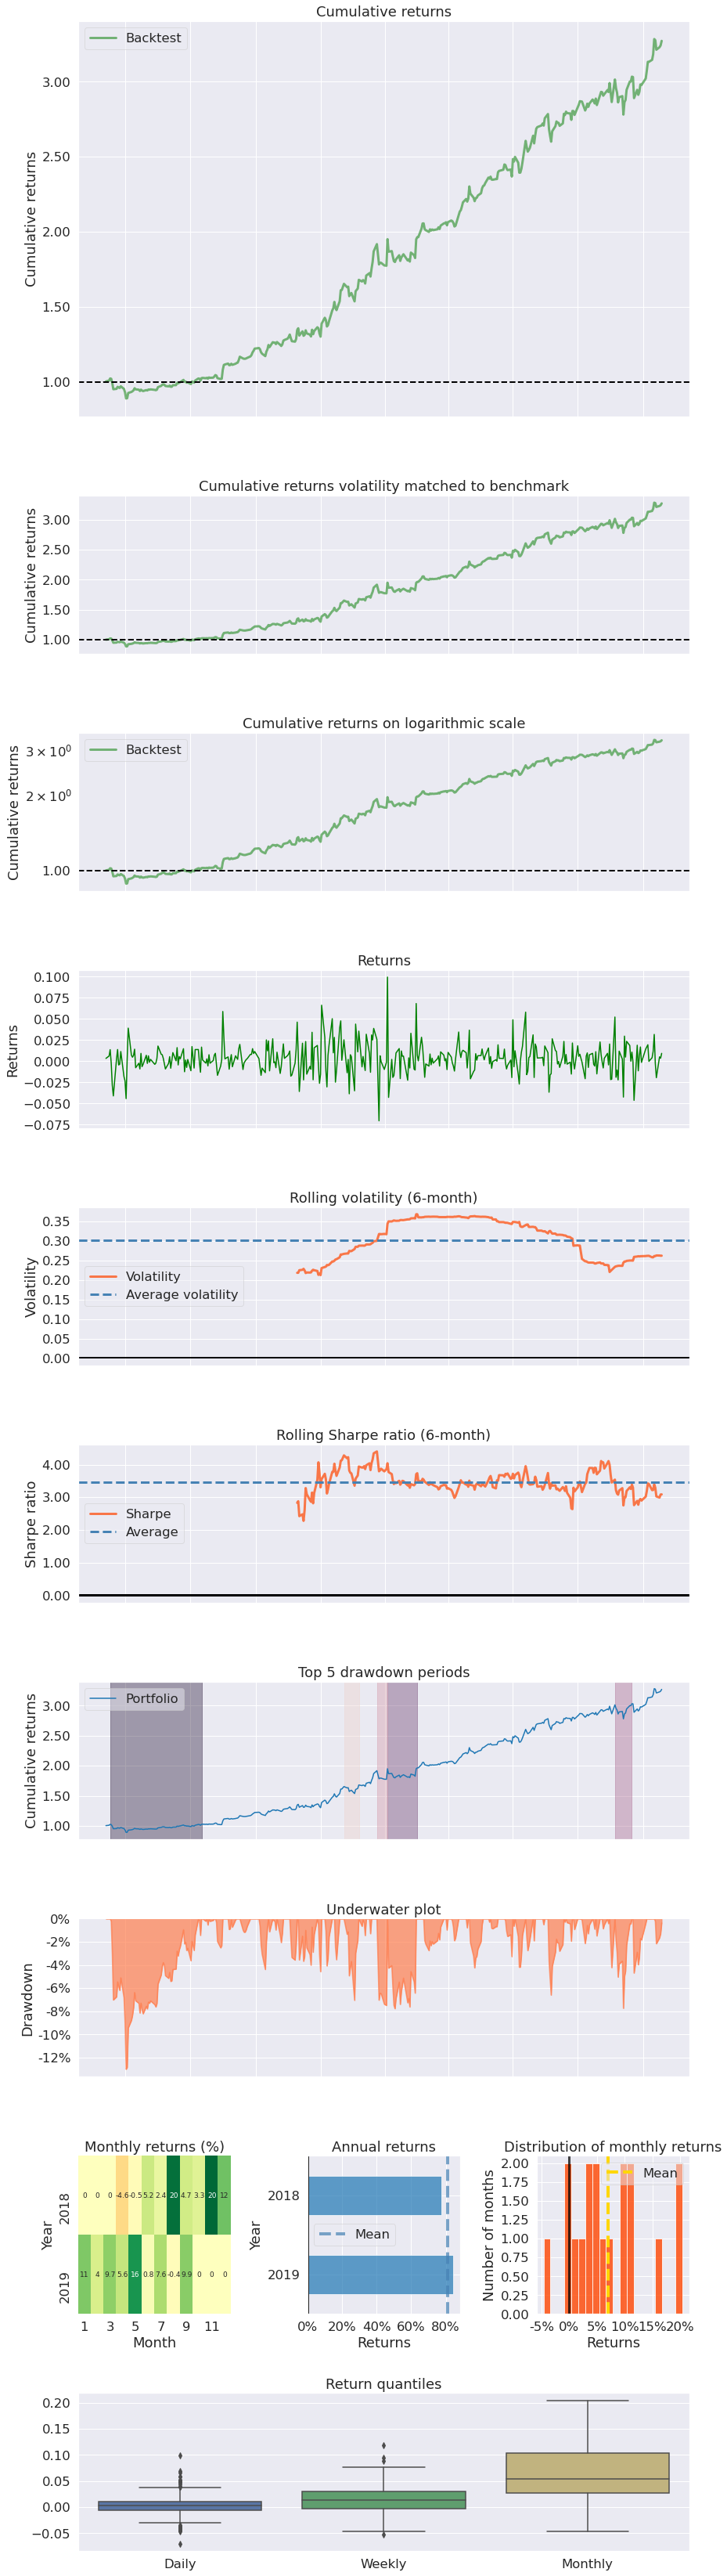

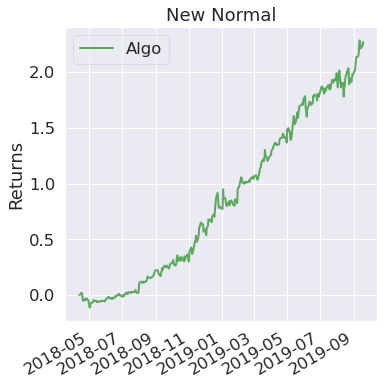

In [77]:
pf.create_full_tear_sheet(Predicted_LSTM['lstm_return'])

### Technical Analysis pyfolio Result

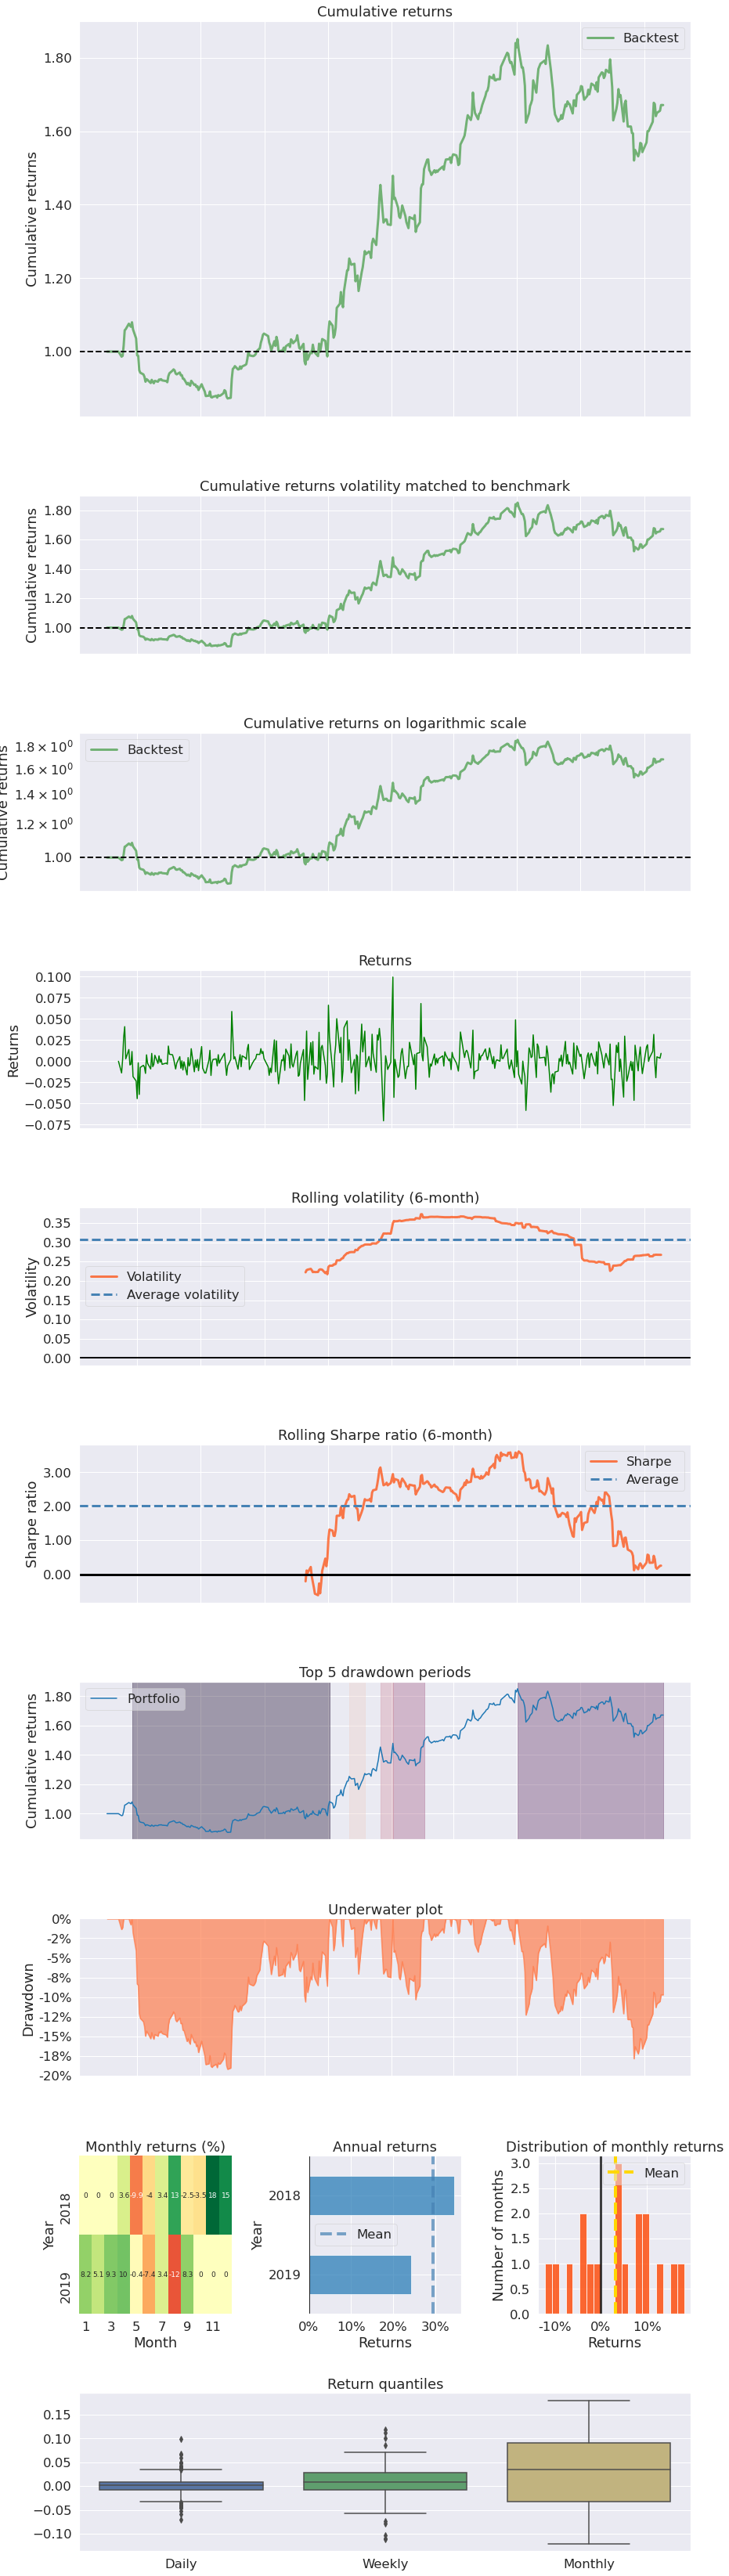

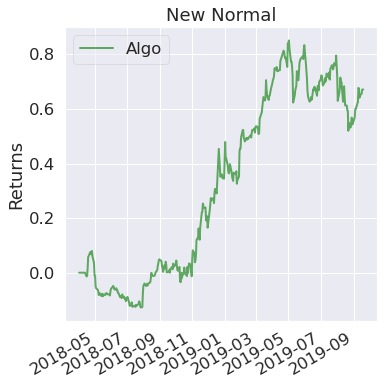

In [78]:
pf.create_full_tear_sheet(signals_df['ta_return'])